# Feature extraction from images

The generative AI part of this notebook requires an AWS account with bedrock model senabled.

In [1]:
%pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [5]:
import ipywidgets as widgets
from IPython.display import display, Markdown, JSON, clear_output
import textwrap
import helpers as aws
import os, json
from tabulate import tabulate
import cv2 
import matplotlib.pyplot as plt 
from contextlib import contextmanager
import textwrap
import numpy as np

local_images = [f for f in os.listdir('.') if f.endswith('.jpg')]

@contextmanager
def image_spinner(out):
    image = open('spinner.gif', 'rb').read()
    with out:
        clear_output()
        display(widgets.Image(value=image, width=100))
        yield
        clear_output()


def print_wrapped(text, width=80):
    for line in textwrap.wrap(text, width):
        print(line)

# Traditional Feature Engineering

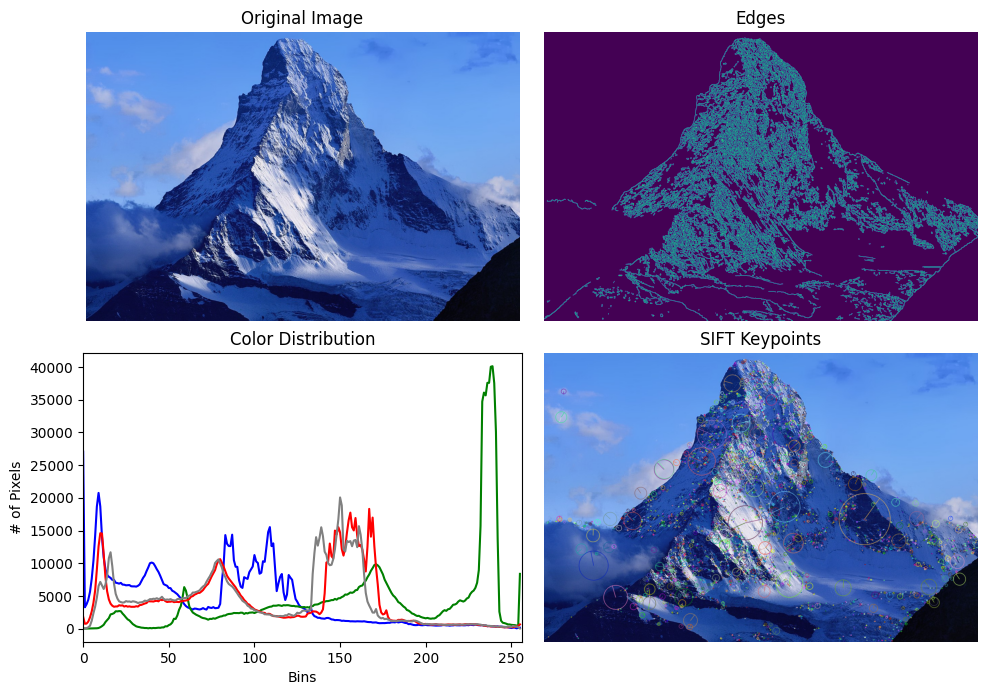

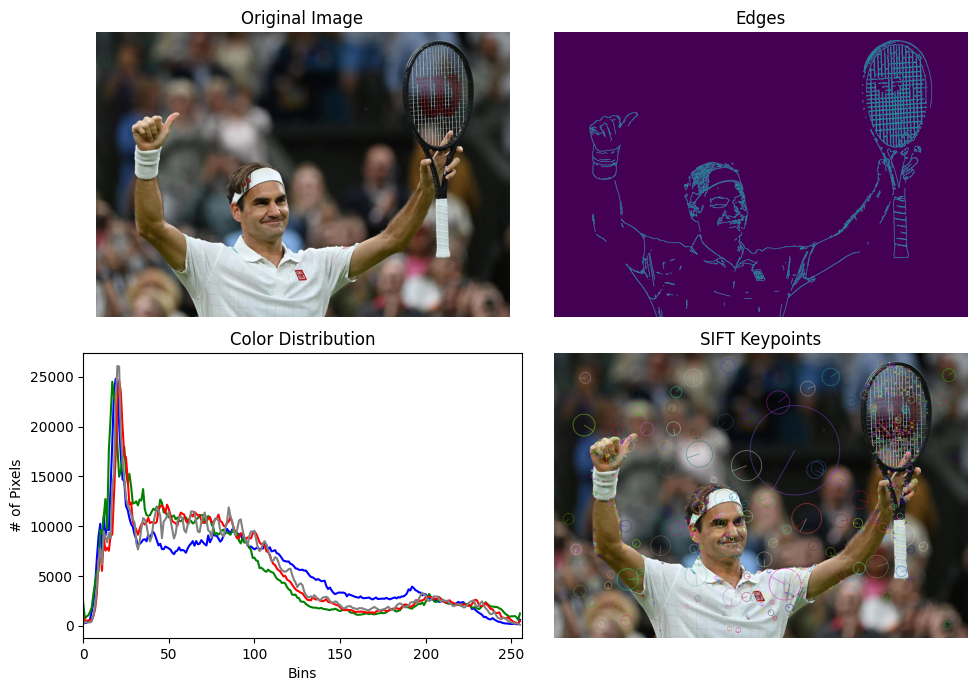

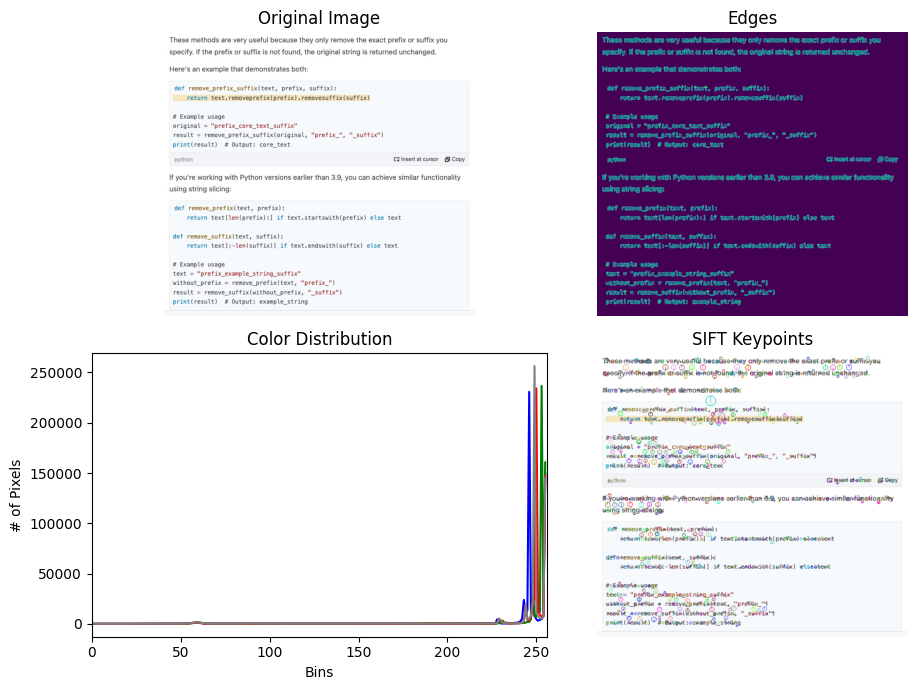

12


In [13]:
def plot_image_edges(file):
    # Load the image
    image = cv2.imread(file) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Display the original image and the edges
    plt.figure(figsize=(10,7))
    plt.subplot(2, 2, 1)
    plt.title('Original Image')
    plt.axis("off")
    plt.imshow(image)

    # display canny edges
    edges = cv2.Canny(gray, 100, 200)
    plt.subplot(2, 2, 2)
    plt.title('Edges')
    plt.axis("off")
    plt.imshow(edges)

    # display harris corners
    # dst = cv2.cornerHarris(gray, 3, 5, 0.1)
    # corners = dst > 0.05 * dst.max()
    # coord = np.argwhere(corners)
    # img = image.copy()
    # for y, x in coord:
    #     cv2.circle(img, (x, y), 3, (0, 0, 255), -1)

    # plt.subplot(2, 2, 3)
    # plt.title('Harris Corners')
    # plt.axis("off")
    # plt.imshow(img)

    # display color histogram
    blue_color = cv2.calcHist([image], [0], None, [256], [0, 256]) 
    red_color = cv2.calcHist([image], [1], None, [256], [0, 256]) 
    green_color = cv2.calcHist([image], [2], None, [256], [0, 256]) 
    gray_scale = cv2.calcHist([gray], [0], None, [256], [0, 256])

    # Separate Histograms for each color 
    plt.subplot(2, 2, 3)
    plt.title("Color Distribution") 
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    plt.plot(blue_color, color="blue")
    plt.plot(green_color, color="green")
    plt.plot(red_color, color="red")
    plt.plot(gray_scale, color="gray")
    plt.xlim([0, 256])

    # display sift features
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)
    img = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.subplot(2, 2, 4)
    plt.title('SIFT Keypoints')
    plt.axis("off")
    plt.imshow(img)

    plt.tight_layout()
    plt.show()

for file in local_images:
    plot_image_edges(file)

print(12)

# GenAI based feature engineering

In [6]:
prompts = aws.image_prompts.list()

out_image = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '400px'})
out_text = widgets.Output(layout = {'padding': '0px 50px', 'max_width': '1000px'})

opt_image = widgets.Dropdown(description='images', options=local_images, value=None)
opt_prompt = widgets.Dropdown(description='prompt', options=prompts, value=None)

image = None

def on_image_change(*args):
    global image
    opt_prompt.value = None
    out_text.clear_output()
    image = open(opt_image.value, 'rb').read()
    with out_image:
        clear_output()
        display(widgets.Image(value=image,width=300))

def on_prompt_change(*args):
    text = ""
    if image == None: return
    with image_spinner(out_text):
        text = aws.create_image_description(image, opt_prompt.value)

    with out_text:
        clear_output()
        display(Markdown(text))


# observe changes
opt_image.observe(on_image_change, 'value')
opt_prompt.observe(on_prompt_change, 'value')

# display
form_data = widgets.GridBox([opt_image, opt_prompt], layout = {'margin': '0px 0px 20px', 'grid_template_columns': 'min-content min-content'})
display(widgets.VBox([form_data, widgets.HBox([out_image, out_text])]))

# Feature extraction from audio (speech)

To enable the demo, download podcast from [here](https://podcast.datenschutzpartner.ch/273-outsourcing-cloud-behoerden-kanton-zuerich-david-rosenthal) and store it in an S3 bucket. Then update the s3 location for the transcribe job

In [17]:
import time
mp3_s3_location = 's3://drweb-playground/media/podcast-swissgerman.mp3'
aws.s3_download_location(mp3_s3_location)

job = aws.TranscribeJob('podcast-swissgerman-2', mp3_s3_location, 'de-CH')
job.start()

max_count = 300
progress = widgets.IntProgress(
    value=0,
    min=0,
    max=max_count,
    step=1,
    description='Transcribing:',
    bar_style='success',
    orientation='horizontal',
    layout=widgets.Layout(width='50%')
)
display(progress)

count = 0
while count <= max_count:
    progress.value = count
    if job.is_finished(): 
        break
    time.sleep(1)
    count += 1

text = job.get_transcript()
Markdown(text)


IntProgress(value=0, bar_style='success', description='Transcribing:', layout=Layout(width='50%'), max=300)

Guten Tag. Mein Name ist Martin Steiger. In der heutigen Datenschutzplauderreihe freue ich mich sehr, einen Spezialgast und Wiederholungsgast begrüssen zu dürfen. Der David Rosenthal. David, einmal mehr. Herzlich willkommen Ja, Sally, Sally, Martin. Das ist wie immer super in deinem Podcast. Lässig bist dabei, David. Das heutige Thema einmal mehr ist Cloud Thematik Outsourcing. Also nicht Kai Thematik, wo du in letzter Zeit natürlich auch viel machst, bei der Gelegenheit wieder mal den Hinweis darauf, dass ihr bei Fischer ja eine super Kai Serien haben. Unterdessen glaube es, bei 20 Folgen tun ich sicherheit der Show noch zu verlinken. Aber eben wir haben immer noch ganz klassische Outsourcinghema. Heute habe ich dich eingeladen, dass wir über das Outsourcing beim Staat reden, weil es gibt. zwei Entwicklungen gerade im Kanton Zürich. Es gibt einen Vorentwurf über das Gesetz über die digitalen Basisdienste. Dort hat es einen umstrittenen Paragraph 17 und die Datenschutzbeauftragung vom Kanton Zürich, die hat den Leitfaden für die Gemeinde veröffentlicht. Microsoft 365 hat die schon zu verlinkt. Wenn man dort rein schaut, dann stolpere ich zumindest so über das eine oder andere auch mit Blick auf meine Eigentätigkeit. Du machst natürlich auch sehr viel, vielleicht noch viel mehr in diesem Bereich. Darum legen wir doch los. Wunderbar. Genau Ich habe jetzt mal als erstes einfach den Leitfahrt aufgerufen, aber auch den Gesetzesentwurf und werde das mal vielleicht durchstrehlen und mal schauen, was da so steht. Die Leitfaden von den Datenschutzbeauftriter ist auch als Anleitung gedacht. Es gibt auch eine Checklisten, weil die Datenschutzbeauftriter muss amigs auch Vorabkontrollen machen, damit Gemeinden das einsetzen, muss 160 Gemeinden im Kanton Zürich. Das Erste, was ich noch interessant finde, ist das Thema Rechtsgrundlagenanalyse, wo da gefordert wird. Und eine Klassifizierung von den Daten, dass man so die Daten muss einteilen. Und das entspricht jetzt auch aus meiner Sicht nicht ganz dem, was man jetzt als Unternehmen als Private würde machen. Darf ich. Wie sieht das aus mit der Klassifizierung? Ja. Also, das ist ein bisschen ein Problem. Das, glaube ich, historische Gründe hat. Das wird ja. Es gibt ja die klassische Unterscheidung im Datenschutz zwischen den normalen Personendaten und den besonders schützenswerten oder im im Kanton Zürich den besonderen Personendaten. Das ist klar, dass es das braucht, weil es da zum Teil unterschiedliche rechtliche Grundlagen braucht, um die Sachen zu beurteilen spielt beim Outsourcing aber eigentlich nicht in so einer Rolle. Und nach meiner Erfahrung wird auch immer alles so gemacht, dass der Sicherheitsstandard eigentlich auch für die besonderen Daten gilt. Aber dann gibt es noch eine Spezialitäten, die ich in der Diskussion um die ganzen Cloud Geschichten erlebt habe. ich nie auflösen, ist, dass man jetzt anfängt, nur zu differenzieren zwischen einem normalen Amtsgeheimnis und einem besonderen Amtsgeheimnis. Weil das gibt es eigentlich nicht im Schweizer Recht. Das ist aus meiner Sicht einfach das. Das ist nicht da. Und es gibt auch nicht ein besonderes Berufsgeheimnis und ein nicht besonderes Berufsgeheimnis. Es gibt höchstens verschiedene Rechtsgrundlagen für das Amtsgeheimnis, aber das Amtsgeheimnis, die Straffolge sind 23 DGB und beim Berufsgeheimnis d 21 oder dann so Namen wie Krankengesetz. Und die muss man natürlich zum Teil auslegen, was sie bedeuten. Und das ist auch der Hintergrund von dem. Aber es gibt nicht jetzt ein Amtsgeheimnis, das schärfer ist als andere einfach von der Natur her. Und das Ganze kommt eigentlich aus einer Diskussion, dass natürlich die Datenschutzbeauftragte und auch gewisse andere Datenschutzbeauftragte in anderen Kantonen irgendwo gemerkt haben, dass sie nicht alles in einen Topf werfen können. Und dann haben sie quasi wie die Figur von dem besonderen Amtsgeheimnis erfunden. Es ist aber so, dass wenn man schauen, was eigentlich die verschiedenen Gesetze in den Kantonen, wo quasi die Amtsgeheimnisse umschreiben, definieren sie eigentlich genau nicht das machen, was Datenschutzbeauftragte sagen. Es ist richtig. Man muss, wenn man will, als öffentlich sogar noch etwas bearbeiten. An Personendaten muss man muss man das analysieren, weil man darf das ja nur mit einer Rechtsgrundlage machen und dort muss man beim Outsourcing auch schauen. Gibt es irgendeine Geheimhaltungsbestimmung, wo der weitergabe an den Outsourcing Provider nicht an irgendeinen dritten, sondern an den, der für einem selber schafft, ob dort eine Geheimhaltungspflicht entgegensteht. Und das bedeutet, man muss dann, wenn man die Steuerverwaltung in das Steuergeheimnis anschauen, wenn man im Sozialversicherungsbereich ist. Die dort muss ich jeweils anschauen, ob dort etwas drinnen steht, wo sagt Nein, du darfst das nicht mehr provider gehen. Aber dort steht nichts normalerweise so drinnen. Und wir gehen davon aus, dass eigentlich alle die Geheimnisse, die da definiert sind, dem nicht entgegenstehen. Was wir auf den Rekord auch Datenschutzbeauftragten von diversen Kantonen sagen. Es ist ihnen klar, dass da nichts dem entgegensteht. Aber das muss man durch kontrollieren. Das haben wir zum Teil gemacht. Bei gewissen Kantonen haben die ganze Liste durchgegangen. Und was steht denn jeweils drinnen in den Kanton kantonalen Bestimmungen. Es steht eigentlich drin, wenn es nicht gibt. Also, das heisst, man benutzt quasi die Rechtsnormen in den Kantonen, um das Geheimnis einzuschränken, nicht um es strenger zu machen. Und deshalb ist das eigentlich alles etwas, was schon an dem auf dem Bein hinkt. Das heisst, es gibt vielleicht gewisse einzelne Fälle in der Schweiz, also wenn es zum Beispiel den Nachrichtendienst käme oder gewisse andere Sachen, wo man jetzt müsste sagen. Ja, Also, das ist jetzt vielleicht noch ein bisschen eine andere Situation aus anderen Gründen, warum man vielleicht gewisse Sachen nicht würde, würde auch. Aber eigentlich gibt es die Unterscheidung so gar nicht. Das heisst, die Gesetze stehen dem nicht entgegen, wenn halt gewisse Voraussetzungen erfüllt sind, dass es halt eben sicher ist und dass es einigermassen unter Kontrollen ist. Aber derzeit. Die Differenzierung ist ja von Bedeutung, weil die Datenschutzbeauftragung vom Kanton Zürich sagt, anders als beim allgemeinen Amtsgeheimnis stehen die Daten unter dem besonderen Amtsgeheimnis und dem Berufsgeheimnis einer Auslagerung in Cloud von Microsoft, Microsoft 365 entgegen, sofern die Auslagerung eine Offenbarung an Microsoft beinhalten. Es ist keine Offenbarung, wenn der Auftragnehmer er Hilfsperson sagt, das aber bei Microsoft und vergleichbaren Unternehmen nicht der Fall. Und in dem Ganzen schwebt natürlich wie immer noch der US Cloud Act, der immer schön erwähnt wird. Da bei dem Potpourri. Das kann ja so eigentlich nicht sein, mit Blick auf die Praxis. Nein, nein, da bringt sie Sachen durcheinander. Und das Spannende, das, was ich auch schade finde an dieser ganzen Sache ist die Begründung ja nie wirklich. Es sind alles immer nur Behauptungen. Es sei so auch die Geschichte mit der Hilfsperson. Das ist einfach nicht so Also nach ihr wäre jeder Cloud Einsatz in der ganzen Schweiz von allen Banken. Es wäre alles hoch illegal, müsste man alle anzeigen. Und so sieht das ausser ihr eigentlich auch praktisch niemands. Dort steht sie auch unter den Datenschutzbeauftragten ziemlich alleine da, wo sie natürlich nicht in dem Sinne äussern oder sich wollen äussern, weil Sie wollen ihnen auch nicht in den Rücken fallen. Aber das ist ein bisschen das Problem, weil natürlich sind das Hilfspersonen, weil sie helfen. Ja, quasi Wiederverwaltung, ihre Daten zu sichern, die Sachen umzusetzen. Das heisst nicht, dass ich denen alles dürfe geben, als einfach etwas zur Hilfsperson zu erklären und dann einfach jetzt Daten rüberzuschieben. Das geht natürlich auch nicht Aber das ist ein bisschen das Problem. Man muss dort noch sagen, es gibt dann noch eine andere Bestimmung im zürcherischen Recht, wo Auslagerungen betrifft, wo es noch einen Sondertwist gibt. Den erwähnt sie eigentlich fast nicht. Dort wäre noch eher eine Diskussion möglich. Wie funktioniert das jetzt genau. Aber das sind natürlich Hilfspersonen. Und ihre Aussage, dass das mit dem Berufsgeheimnis nicht ginge. Das betrifft vor allem im Z die Spitäler, weil die sind ja auch zu ihr gekommen. Die sind in der Kärnt im kantonalen Recht. Und dort versucht sie überall quasi wie etwas dazwischen zu schieben, weil sie will einfach nicht, dass irgendwo mit Cloud genutzt wird. Und jetzt bringt sie das ist meine Interpretation alle möglichen Gründe auf, äh, warum die Cloud illegal, strafbar oder whatever ist. Aber ich habe noch nie eine nachvollziehbare Begründung gesehen wo sie die Sachen herleiten. Und deshalb stimme ich dir zu. Das ist irgendein Potpourri, das so meiner Meinung nach einfach nicht aufgeht. Im Tätigkeitsbericht. Das haben wir kürzlich thematisiert. In dem Podcast steht ja sogar drin. Hilfspersonen müssen auf die Personenebene einzeln zur Geheimhaltung verpflichtet werden. Das wäre jetzt bei einem Anbieter in Microsoft rein logistisch oder nicht machbar, selbst wenn man das für richtig würde halten, was ich nicht für richtig halte. Ja gut. Das passiert schon. Aber es passiert nicht durch das öffentliche Organ selber, sondern das öffentliche Organ geht zu einem Provider und sagt wirst du Provider musst bei deinen Mitarbeitern die Erklärungen einholen. Und das passiert also das. Das ist auch abgesehen davon überall vorgesehen. Das macht auch mein das oft machen alle anderen auch. Und das Spannende ist schon dran. Wenn man das, was sie sagt, wirklich ernst nehmen würde, dann müsste auch jeder Cloud Provider in der Schweiz eigentlich illegal sein. Und jetzt sind wir gerade beim nächsten Punkt. Es wird immer von Cloud geredet. Was ist eigentlich Cloud? Du hast vorher auch den Gesetzesentwurf erwähnt. Dort ist heute davon. Man darf in die Cloud gehen. Aber der Gesetzesentwurf definiert nie, was Cloud ist. Und eigentlich sind es ganz normale Outsourcing Provider. Also, wenn man das ernst nehmen würde, was da drin steht, kann man auch jetzt gerade alle Lösungen, die da sind, als illegal erklären, weil die bezeichnen sich auch alle als Cloud-anbieter. Und dann ist alles, was wir heute schon machen, ausser wir lassen sie auf dem eigenen Server laufen. Alles hoch illegal, hochverboten, strafbar und müssen wir. sofort aufhören. Und das zeigt das Gott natürlich so nicht. Du hast jetzt die Verträge erwähnt. Und eben ich meine einen einzelnen Microsoft- Mitarbeiter. Auch wenn jetzt da öffentlich-rechtliche Kunden Microsoft Cloud nutzen, der weiss das ja nicht. Der wird nicht gezielt auf eine Gemeinde oder auf den Kanton verpflichtet, sondern ist einfach teils im Arbeitsverhältnis, das Innenverhältnis bei Microsoft und gegen aussen tut man das auch vertraglich absichern. Also, ich glaube, das ist immer noch so der Stand der Dinge eben. Es geht ja nicht anders, was da gefordert wird, dass auf die Personen. nicht zu machen, direkt. Das funktioniert, wenn überhaupt nur bei kleinsten Anbietern, die irgendwie nicht viele Fluktuationen haben. Das ist völlig richtig. Und das lenkt auch. Also, das ist das, was heute auch akzeptiert ist. Übrigens bezeichnend ist Wir diskutieren im Bereich der öffentlichen Verwaltung Probleme, die eigentlich nicht Probleme sind. Und die Art, die wirklich Probleme sind, diskutieren wir nicht in dem Bereich. Also ein Thema zum Beispiel, was wir sehen bei den grossen Cloud Provider, weil wir haben ja viel mit Banken und all den anderen zu tun. das haben, ist beispielsweise, wie gut sie in der Lage sind, herauszufinden, wer wen auf die Daten zugriffen hat oder hätte können. Die FINMA zum Beispiel verlangt, dass es möglich ist, bei gewissen Banken, dass sie herausfinden können und nachfragen können, welche Person also namentlich hat zu welchem Zeitpunkt auf die Daten zugriffen. Und mit dem haben zum Beispiel die Cloud Provider zum Teil wir oder sie wollen es nicht rausgehen aus Datenschutzgründen. Da haben wir müssen ziemlich lieben, um das H zu kriegen. Und es ist auch heute noch bei gewissen Providern schwierig sicherzustellen, dass wirklich alles gelockt wird. Und dann ist die Erklärung, die Vertraulichkeit erklärt. Das ist dann das kleinste Problem. Also, wir sollten über so Sachen diskutieren. Dort spielt die Musik und nicht bei denen aus meiner Sicht Scheingefechte, die da geführt werden, in einem anderen Bereich, ohne zu wissen, wie das überhaupt genau funktioniert. Das ist ja das Problem. Das Problem passt gut zu einem Thema, das wir immer wieder begegnen mit Microsoft, aber auch mit anderen. Wie kommt man die Verträge an. Also da sind auch die Datenschutzbeauftragte ja, mit mehr als 250 qualifizierten Nutzern. Ich glaube, es ist ab 250 nicht mehr als 250 kann man sich den Rahmenvertrag anschliessen von der ehemaligen SIK. Und sonst sagt sie einfach Ja, wenn du kleiner bist als die Gemeinde. Und da sind ja viele Gemeinden zwischen im Kanton Zürich wären kleiner, aber auch bei den Privaten haben das Problem. Man KMU, die nicht die Grösse haben, auch von den Lizenzen vielleicht her und so braucht ja für das, was man machen, eine häufig E fünf Lizenz und Enterprise Lizenz. Wie siehst du da das Thema? Vielleicht eben einerseits bei der Verwaltung, aber natürlich auch breiter bei den Privaten. Ja, da muss man ein bisschen kreativ sein. Also, ich habe übrigens selber für mein Notebook auch eine einzelne E fünf Lizenz mit allem, was es gibt, wie Local Data Storage und Lockbox und alles. Also, das kann man schon machen. Das ist eine kommerzielle Frage. Ein bisschen mühsam und kreativ muss man werden, wenn es um die Verträge geht. Jetzt ist es aber bei Microsoft so Das hat auch das Zeit gebucht, dass sie erkannt haben, dass sie ihr Business viel schneller machen können, wenn Sie die Bestimmungen, die wir verhandel gehabt haben, für die grossen Kunden, also die, wo eben die grossen Verträge haben, dass sie die, die standardisieren und eigentlich jedem zugänglich machen. Das heisst auch im öffentlichen Bereich. Es gibt die SIC Verträge und es gibt. Aber ich sage jetzt einmal Vertragszusätze, wo jeder Kabinet. kommen, ohne dass er etwas speziell Grosses machen, also auch mit weniger als 250, wo im Prinzip 90 % von dem, was jetzt in diesen Siegverträgen drinsteht, an Datenschutzbestimmungen auch enthalten. Was nicht enthalten ist, sind Bestimmungen zum Thema anwendbares Recht, wo es so eine Spezialregelung gibt, die da in der Schweiz gilt für ganz bestimmte Sachen und Gerichtland. Ich bin aber der Meinung, und das sagen wir auch verschiedene Datenschutzbeauftragte, dass kann man mit einem gewissen Risiko. mit einer Risikobeurteilung auch ohne das machen. Und dann hätte man eigentlich im Datenschutzrechtlichen Bereich. Ich rede jetzt nicht von den kommerziellen Sachen hätte man eigentlich die gleichen Bestimmungen, weil die sind verfügbar über einen Zusatz für Behörden, genau gleich wie jetzt zum Beispiel Anwaltsbüros oder Ärzte oder so den Zusatz für Berufsgeheimnisse bekommen. Und dann gibt es noch für Financial Services noch etwas. Jetzt. Das Problem bei Microsoft ist natürlich, dass ich das dann, wenn ich zum Beispiel online mache. machen muss. Natürlich nicht, dass es ohne weiteres anderes ankommt. Das heisst, ich brauche so eine CSP. Nennen Sie das? Das heisst einen Provider, wo dann quasi wieder Händler von Microsoft ist. Und in dem Kanal wissen ganz viele von diesen CSP gar nicht, wie und welche Zusätze es gibt. Das heisst, man muss ihnen da ziemlich genau vorgeben, was sie müssen liefern. Insbesondere auch nur die englische Version, weil die Deutschen haben komische Übersetzungsfehler, wo das Sinnenstellen sind. Und dann gibt es eigentlich keinen Prozess, um diese Z. unterschreiben. Und für das haben wir uns auch einen Trick in dem Sinne ausgedenkt, wie wir das machen. Wir haben nämlich, weil man doch eigentlich unterschriebene Verträge oder irgendetwas, wo das klar ist, haben wir mit CSPs geschaut, wie sie dann rechtlich dastehen. Und ohne das jetzt kompliziert zu machen, ist es so, dass sie eigentlich wie die Funktion. Wir nennen das juristisch ein Bote, ein Empfangs- und Erklärungsbote sind von Microsoft. Das heisst, Sie schliessen die Verträge nicht als Stellvertreter ab, aber sie reichen. das weiter. Und dann haben wir so ein Sätzchen entwickelt, wo wir mit den Providern abmachen für unsere Kunden. Und ich würde das übrigens auch noch dann publizieren, wo der CSP erklärt, dass Microsoft ihm erklärt habe, zu Handen von den Kunden vereinfacht gesagt, dass, wenn der Kunde das akzeptiere, das gegen sich gelten lässt. Und ich habe dann bin dann auf Microsoft Zugang und gesagt Das sagen jetzt eure CSPs, und die haben dann sich zuerst ein bisschen gestreut. weil es hat ihnen doch nicht so gepasst. Aber das wird jetzt die Lösung sein, weil Sie haben es bis jetzt einfach aus internen Gründen immer noch nicht hingekriegt, dass man das Zeug unterschreiben lassen. Und so haben wir zwar mit einem bisschen juristischen Tricks, wenn ich es jetzt mal so sagen will. Super, aber trotz allem mit so etwas haben wir quasi wie die Möglichkeit, dass die kleineren Organisationen wie dokumentieren können, dass die Verträge, dass die Verträge unterzeichnen oder dass sie, dass sie gültig sind, mit den Zusätzen, weil. für das Basis Agreement das MCA. Das kann man schon online machen. Das ist nicht das Problem. Und so habe ich das übrigens persönlich auch gemacht. Ich habe mir das jetzt direkt schicken lassen. Und dann habe ich quasi wie die Erklärung dann in dem Sinne so vereinbart. Und so sollte das eigentlich funktionieren, weil es ist unbestritten, dass Microsoft die Sachen gegen sich gelten lässt, weil sie machen das ja für alle genau gleich. Sie betreiben Cloud nicht für die Grossen, anders als für die Kleinen oder jedenfalls nur mit ganz kleinen Teilen. Und so funktioniert das auch für die Gemeinden. da gibt es auch noch die eine oder andere Kuriosität. Was mir bei Microsoft immer so ein bisschen amüsant auffällt, ist Ich habe natürlich grosse Liebe für Word-dokumente. Also, äh, wo der Rest von der Welt PDFs verwendet, setzt Microsoft unglaublich häufig auf Word oder Sie haben da kein eigenes Format. Und ich finde es immer lustig, weil das Word-dokument oder es wird auch für verbindlich erklärt. Und so ist für mich eigentlich ein Entwurf. Natürlich. PDFs kann man auch bearbeiten et cetera. Also je nachdem, wie man es macht. Aber das finde ich habe ich da recht erstaunlich, oder man hat so einen Vertrag. Und der ist auch irgendwo in der Administrationsoberfläche verlinkt als Word-dokument und so Aber eben Sie akzeptieren es ja so Ja. Also, wenn. Wenn es jetzt um so saubere Governance bei Verträgen geht, auch bei den Versionen. Ich meine, wir haben ja x Verträge sehen wir vorhin. Und jedes Mal müssen wir, wie wir Compares machen und andere Sachen machen und sicher zu sein. Es steht ja nicht drauf, welche Version es ist. Ist es jetzt noch? Hat es sich wieder mal etwas geändert? Ist es so? Also, es ist auch ein Puff, wenn man so sagen will. Und das ist ein bisschen schade. Also, da würde ich eigentlich mehr, äh, Professionalität erwarten. Und wenn man das Ganze dann noch an die ganzen CSPs stellen wo das sie eigentlich nicht wissen. Die haben das Gespür dafür. Dann ist es einfach wahnsinnig schwierig, an die Sachen anzukommen. Bei den grossen Kunden geht das. Dann ist nicht das Problem. Aber wie du sagst, bei den ganzen Kleinen. Und deshalb haben wir so versucht, eben so Sachen irgendwie zu machen. Aber man muss sie quasi wie zwingen dazu. Ich habe Ihnen das schon vor sechs Jahren gesagt. Und sie hat sich nicht bewegt. Also, man muss sie faktisch zwingen und sagen, so machen wir jetzt das. Und jetzt sind wir einfach in einer Situation drinnen. Können euch auch rechtlich wehren. Dagegen es nicht machen, weil eigentlich sind Sie ja froh, weil dann hat man irgendeine Lösung, weil das Problem liegt ja nicht in der Schweiz. Das Problem liegt bei all diesen Hyperscalen, dass alles, was irgendwo relevant ist, auch wenn es eine Vertragsanpassung braucht, von den USA muss kommen. Und das ist die grosse Schwierigkeit. Wenn wir jetzt zum Beispiel so eine FINMA-Anforderung haben, wie Sie vorher gesagt habe, das ist über ein Jahr gegangen, bis man überhaupt da eine Lösung gehabt hat. Und es ist auch jetzt sind noch gewisse Sachen noch nicht überall gelöst. Und das ist nicht nur bei oder auch einen anderen oder so muss man gerechterweise sagen. Aber da muss man halt einfach gewöhnen. Und deshalb hätte ich es jetzt viel besser gefunden. Wenn jetzt die Datenschutzbeauftragte vom Kanton Zürich sich nicht auf so auf die Themen, wo sie wahnsinnig gerne fokussiert, sondern der Gemeinde mal wirklich sagt, wie sie das machen müssen, weil die sind doch völlig aufgeschmissen. Also, woher sollten Sie das wissen, was halt wirklich schade ist bei Microsoft. Und wir reden ja primär bei Microsoft, weil halt das sehr weit verbreitet ist. Natürlich auch in der Schweiz, also marktmächtig. aber eben auch die anderen grossen. Dort ist es zum Teil noch ein bisschen schwieriger oder ein bisschen weniger einfach, was ich immer schon abfinde. Ich meine, über das, was wir jetzt reden. Das könnte beim Online-bestellprozess ein Mausklick sein. Also, ich klicke mir Microsoft 365 oder ich klicke mir eh schon. Ich kann noch anklicken. Hey, ich bin irgendwie eine Gemeinde, ich bin eine Anwaltskanzlei. Ich bin ein Finanzinstitut, wie du sagst, das Ergebnis, wenn man sich einfach ein bisschen Mühe gibt, am Aufwand betreibt, ist eigentlich immer das Gleiche. Also eigentlich laufen da hinter den Kollegen. und bei verschiedenen Beteiligten sehr viele Rädchen, die gar nicht müssten laufen, wenn wir das entsprechend umsetzen. Da bin ich bei dir bin ich mit dir einig. Die Issue ist halt. Und da sind wir nicht nur bei der Microsoft. Ein anderer Fall ist zum Beispiel Open Ei. Das ist auch so eine so eine Firma. Wo, wo eine Tat. Also, wenn, wenn jemand mir würde jetzt einen Vertrag liefern von meinem Team, wo so formuliert ist und gemacht ist wie Open Ai mit mit unterschiedlichen Parteien an, wird es gerade zurückgeschickt. Das. Das geht gar nicht. Aber sie können sich es leisten. weil die Leute wissen das, wie du gesagt hast. Man kommt um das Microsoft- Zeug in vielen Bereichen nicht herum. Jetzt kann man sagen Ok, dann machen wir eine Open Source. Ein anderes Zeug. Das ist eine andere Debatte. Aber wenn die Gelernten zu uns kommen und sagen, Sie wollen das haben wir irgendwie eine Lösung finden. Und das wäre in der Tat einfach. Ich glaube einfach, dass sie so in ihren anderen Sachen drinnen sind und so wenig Leidensdruck haben in dem Bereich, dass das auch noch eine Zeitlang so bleiben wird. Die Sachen lösen sich nicht schnell auch wenn man sagen müssen, das wäre eigentlich sehr einfach. Und genauso bei den anderen bei den anderen Firmen wie bei Open Air. Da haben wir die Erfahrung müssen machen, wie das gegangen ist, bis die schon nur mal das DPA gehabt haben. Also so ein Datenschutz vereinbar. Das ist schon ewig gegangen. Und das wäre zum Beispiel auch etwas, wo ich mir mehr würde wünschen, dass die Aufsichtsbehörden dort zurück machen. Ich bin auch schon zum Beispiel zum EDP gegangen und zu sagen Hilf mir, sage Ihnen, das braucht es nicht nichts passiert, dass dort quasi wie die Aufsichtsbehörden könnten das auch dort den Druck machen, damit das besser läuft. Weil dann sind sonst Leute wie du und ich und Einzelne, die da etwas machen. Aber das. Das hat nicht die Wirkung. Und das wäre etwas, wo ich glaube, die könnte etwas machen, weil sie könnte das realisieren. Das wäre ja nicht schwierig, wie du sagst. Jetzt, statt dass das die Aufsichtsbehörden machen, machen Sie etwas anderes. Eben. Sie tun dann mehr oder weniger hilfreiche Tipps geben jetzt da im Kanton Zürich. Wenn man die Leute von der Gemeinde liest, ist dann plötzlich dreht. Ja, da muss man hybride oder technische Lösungen finden, wenn Sachen nicht in die Cloud dürfen. Da gibt es einen Akronymsalat, gewisse Lösungen, die präsentiert werden. Und wenn man die anschaut, dann sind die Lösungen eigentlich alle nicht so elegant. Man geht da zum Teil neue Risiken rein, organisatorische Risiken, wenn man das umsetzt. Das tut zum Teil den Alltag erschweren. Also, ich habe schon erlebt bei Behörden nicht im Kanton Zürich. Oder sie zum Teil Ihre Daten müssen so pseudonymisieren. Also, Sie dürfen irgendwie im Kalender nicht mehr Namen reinschreiben. Und das führt zum totalen Chaos. Zum Teil. Das wäre dann wohl die Hybridlösung, dass man sagt Ja, wir tun es anonymisieren oder Pseudonymisieren oder Daten liegen nicht an gleichen Ort. Was ist da der Durchblick, David Ja. Also, I-. Ich halte das für für daneben. Das ist also ich. Ich kenne die Geschichte. Ich kenne sie an verschiedenen Orten. Da wird leider so eine enorme Verunsicherung betrieben, was die Cloud betrifft, in dem Zusammenhang, dass die Leute und das verstandig nicht mehr wissen, was es ist. Und dann sagen sie, bevor ich da jetzt irgendwie ein Problem habe und ich doch einfach sage, ich nutze es eigentlich nicht. Ich möchte es zwar, aber eigentlich nutze ich es dann doch wieder nicht. Und dann, äh, lasse ich das einfach den Benutzer delegiere ich ab, dass sie das. Problem für mich lösen. Das kann es einfach nicht sein. Und das ist leider der Ansatz, den man in Zürich hat, der Datenschutzbeauftragt hat, aber auch der Digibasisentwurf. Und der ist eigentlich gedanklich auf dem Aufbauend, dass es nicht läkt, dass man zum Beispiel vertragliche Vereinbarung hat mit dem Provider, dass es nicht läkt, dass der Zugriff für ihn schwierig ist, sondern es muss eigentlich so gesichert sein, dass der Provider selbst wenn er will und entgegen jedem Vertrag einfach technisch nie auf die Daten zugriffen kann und nicht einfach, dass es verschlüsselt ist, sondern dass es einfach nicht geht. Und so, wie wenn der Vertrag nicht würde existieren. Das ist die Vorgabe. Und mit dem lässt man kann man m 3 65 einfach schlicht nicht relevant betreiben. Das geht nicht. Und die Lösungen, die ich anbiete, wie das Double Key Encryption. Das ist fadenscheinig. Das funktioniert so nicht. Das sagt auch Microsoft selber. Das setzt sich auch auf das Das kann man vielleicht für ganz wenige Dokumente einsetzen, aber nicht für all das, was du vorher beschrieben hast. Das sind alles Pseudolösungen. Und das hat sie natürlich müssen bringen, weil sonst kann sie ihr Konzept nicht durchsetzen. Aber im Wesentlichen heisst das Cloud wird abgeschossen. Und das ist genau das Gleiche mit dem Digibasisvorschlag, weil der sagt, ich darf Cloud nutzen, in der Schweiz und den Dreh rausgehen in der EU. Also, das finde ich auch noch spannend, wenn es ausgeschlossen ist, dass der Cloud Anbieter kann auf die Daten zugriffen. Ich will aber genau, dass der Cloud-anbieter auf die Daten zugriffen kann. Also, ich gehe ja in die Cloud, damit er M Daten auf Spam brieft, M Daten auf Sicherheitsbedrohungen brieft, M Daten in der Mailbox parat. ich in der Mailbox suchen kann nach meinen Daten. Das ist ja genau das, was er machen soll. Und in den letzten 20 oder dreissig Jahren hat auch niemand das Problem gehabt, wenn ich zu einem Outsourcing Provider gegangen bin und gesagt habe, Da hast du meine Daten. Du. Du sollst sie nicht jedem zeigen, sondern nur ausgewählten Mitarbeiter meinetwegen und das machen. Aber er kann und darf das sehen. Das ist immer erlaubt gewesen. Ist auch weiterhin erlaubt. Und jetzt kommt man plötzlich und sagt Bei der Cloud sagt das anders. Und ich rede nicht einmal von ausländischen Clouds. Nur der Digibasisentwurf betrifft auch alle Schweizer Cloud-provider. Auch die sind eigentlich alle nach der Lösung, wo dort der Gesetzgeber oder eine Stelle im Kanton Zürich, wo das vorgeschlagen hat, wäre, kann man alle abschiessen. Also, die funktionieren nicht. Leider wird nicht definiert, was Cloud heisst. Das habe ich schon gesagt gehabt, aber die Reaktion auf den Paragraph. 17, wo du vorher erwähnt hast, ist auch entsprechend heavy gesehen. Ich habe mir lange überlegt. Soll ich jetzt die Zeitaufwände dort auch etwas schreiben dafür. Aber ich habe gefunden. Nein, das ist einfach so total daneben, was da drinnen steht. Das geht völlig am Problem eigentlich vorbei. Man sollte viel lieber schauen, dass man über die wesentlichen anderen Risiken diskutiert, die zum Teil auch erwähnt werden. Also Abhängigkeitsrisiken, beispielsweise Sicherheitsprobleme, die es gibt, aber einfach mit so einer absoluten. Hautlösung, die End zu End Verschlüsselung, wo man dann auch sagen, das führt nicht einmal das Gutachten, wo man dort einmal im Auftrag gegeben hat, seit quasi das Buch ist, wenn man dort schauen im Addendum, wo die Autoren reingeschrieben haben. Sie haben sich ja selber distanziert davon. Sie haben ja selber geschrieben. Sie verlangen das nicht. Und sie widersprechen auch nicht, dass es völlig impraktikabel ist. Und deshalb geht es eigentlich darum, die Cloud abzuschiessen. Und dann finde ich, sollte man das auch offen deklarieren. Wieso sagt man denn das nicht offen? Ich meine, digitale Souveränität ist das Schlagwort, was politisch, wenn es sehr beliebt ist. Wieso getraut man sich das nicht Ich weiss es nicht. Also, ich habe bis jetzt auch noch nie irgendwo aus dem Ecken etwas gehabt, der bereit gewesen ist, über das Thema wirklich sachlich zu diskutieren. Man will nicht darüber diskutieren. Und dann gibt es einfach so Stimmen wie von mir. Und ich. Ich sage, was ich denke zu diesen Sachen. Ich habe das auch alles ausführlich begründet. Aber es kommt nichts. Es wird einfach gesagt. Ist verboten, ist illegal. Geht nicht. Muss so sein. Es kommt nichts. Und deshalb. Ich kann die Frage nicht beantworten. Bin ich die Falsche, wo du fragst. Ich. Ich kann es nicht sagen. Und ich will nicht über Motiv irgendwie, äh, mir Gedanken zu machen, sondern ich sehe einfach, was dasteht. Und das geht einfach nicht auf. Was ich aber auch sehe, ist, dass zum Beispiel im Kanton Zürich die Leute wahnsinnig verunsichert sind, weil es gibt ja ganz viele öffentliche Organe. Es gibt ja nicht nur die Kantone, also die öffentliche Verwaltung. Die sind gross. Die haben ihre eigenen Leute, die sich eine Meinung. bilden. Es gibt ganz viele kleinere Institutionen, die ganzen Spitäler, die ganzen irgendwie Bildungseinrichtungen. Ganz die ganzen Gemeinden, wo du vorher erwähntest. Alle die, die hören das von ihnen und sind total irritiert und werden das nicht machen. Und dann bleibt das alles irgendwo stehen, statt dass man dort einmal wirklich eine Diskussion hat, wo einigermassen fundiert ist. Auch die ganze Geschichte mit dem Cloud Act. Das ist alles. dort wird das Zeug falsch zitiert, wo dort hinten ist. Da bringt man die Sachen durcheinander. Abgesehen davon wird, äh, wird die ganze Geschichte ja noch auf der Ebene vom DSG jetzt dann mit dem Bundesrat so sein, dass er wird erklären, dass die USA einen angemessenen Schutz bietet. Also das Zeug ist irgendwie auch vom Tisch. Das ist vermutlich einer von den Gründen, wieso man jetzt auf das Berufs- und Amtsgeheimnis ausweicht, weil die Datenschutzgefahr sind wegbricht als Begründung für das Ganze. Und dort muss ich einfach sagen, dort wird so viel gemischelt. Aber die normalen Entscheidungsträger, die Leute, die alten Leute, die das mit umsetzen. Die sind total überfordert mit dem. Und das ist das Problem. Ich weiss schon, was ich meine. Und die Datenschutzbeauftragte hat auch ihre Sache. Aber die Leute dazwischen, die hören einfach das und die kommen nicht mehr daraus Ja, logisch. Also, ich meine, das liest man ja. Eine Datenschutzbeaufbereitung hat auch eine gewisse Autorität. Also, sie kann auch eingreifen, wenn sie wollen. Übrigens noch ein interessantes Thema, so Datenschutzbeauftrite in der Schweiz tun sich gern öffentlich ausreben. Sachen sagen rechtswidrig, illegal und so Ich habe jetzt noch nie erlebt, dass etwas in einer Anzeigepflicht nachgekommen wäre, wenn dann etwas doch anders aufgesetzt worden wäre. Ja. Gut. Also, das ist, äh. Das ist nochmal ein Thema für sich. Wir haben uns ja auch schon mal in einem Podcast da unterhalten, was jetzt alles der Edebe aus Bern für Datenschutz weitereingehalten, was aus meiner Sicht keine Rechtsgrundlage gibt. Und wo er dann halt immer sagt Ja, gut, so im Stil von einem Diskussionsbeitrag. Es sollte dann einmal das Gericht darüber entscheiden. Aber das passiert in der Schweiz ja eigentlich nicht. Und wenn ich schaue, wie viele Kantone schon quasi in die Cloud gehen und das machen. Sie wollen einfach nicht so gross darüber reden. Auch die anderen Datenschutzbürfen. Nein, Sie wollen einfach nicht darüber reden,, weil es ist in allen klar, dass das passiert. Und wenn man dann kommt mit so Lösungen wie Ja, wir machen keine sensiblen Daten drin dann. Dann schiebt man alles auf Benutzer ab, anstatt dass man dort mal ansteht und sagt Nein, wir machen das, oder wir machen das alles nicht. Man kann meinetwegen auch gehen und sagen, man macht alles mit einer Open-source Lösung. Ich glaube nicht, dass das besser wird, sondern dann nennt man andere Themen. Aber irgendwie so einfach nicht richtig. Es gibt jetzt auch den Ansatz, dass man zum Beispiel versucht, das Ganze. schöner zu verpacken, indem Microsoft selber noch zusätzliche Verschlüsselungsebenen eingeführt hat. Und dann kann man sagen Ok, und der Schlüssel wird jetzt von einer anderen Stelle verwaltet, nicht der Gemeinde, sondern nochmal von einem anderen Servicedienstleister. Und der wird jetzt quasi so ein Bring your own Key und Customer Managed Key wird dann bei Michael. Soft hat noch eine zusätzliche Ebene verschlüsselt. Und dann kann man das alles noch überwachen und kontrollieren. Und das kostet furchtbar viel Geld, weil jeder will dann sein Auto für etwas bezahlt haben. Aber es ändert nichts an der Tatsache, dass der Schlüssel am Schluss bei Microsoft liegt, weil sie muss ja die Daten auch entschlüsseln, um damit etwas zu machen. Und dann kann man vielleicht darauf hoffen, dass das jetzt etwas nicht auffällt. Aber irgendwo müssen wir uns dann halt einfach dazu bekennen. Und wenn wir das machen. dann muss man halt über die Risiken diskutieren, die dort dabei sind. Auch das Gutachten, das ich vorher erwähnt habe, sagt, man kann das abwägen gegeneinander. Es gibt ja nicht nur den Kontrollverlust, wenn ich etwas an Microsoft gebe, sondern es gibt auch den Gewinn an Datensicherheit. Und das ist ja auch ein Anspruch, den ich habe gegenüber dem Staat. Ich einen Anspruch nicht nur darauf, dass er meine Daten nicht expost gegenüber dem Provider. Wenn ich sage, das segen Kontrollverlust. Ja, kann man sagen. Ist es so, wenn es nicht die Gemeinde ist, wo das auf ihrem Server hat. Aber ich habe auch einen Gewinn und und. Und alle Staatsrechtler sagen, das muss ich gegeneinander abwägen. Aber auch die Diskussion passiert nicht. Und da müsste ja eigentlich eine Datenschutzbeauftragte im Kanton Zürich müsste ja auch ein Interesse daran haben. Könnten wir jetzt vielleicht nicht sehen, ob die Cloudlösungen unter bestimmten weiteren Bedingungen. Da kann sie kommen und sagen Wir brauchen eine E fünf Lizenz. Zum Beispiel kann man darüber diskutieren. Ich müssen dies und das machen. Ich müssen es so und so aufsetzen. Ich müssen das mit den Verträgen sicherstellen. Und dann kann man dort einen Sicherheitsgewinn haben. Und den können wir miteinander abwägen, oder? Beziehungsweise Sie muss gar nicht abwägen, sondern es muss die Gemeinde machen. Aber dann kommt man in eine Diskussion hinein, statt einfach mit der ist illegal, Keule zu kommen. Und das ist die Diskussion, die fehlt, ist illegal, denn das Schlagwort oder eben Komplexitätserhöhend. also die Cloud Access Security Broker CSB oder die Ebene, wo man hineinzieht. Also, das hat die unglaubliche Komplexität abgesehen von den Kosten, die man hat, wenn man jetzt gerade mit den Crowdstrikes so erlebt oder was so Komplexität bedeuten oder auch mit der Klassifizierung. Da gibt es so schöne Matrix, wo dann erwartet wird von den Anwenderinnen und der Anwendern, dass sie bei allem, was sie machen, dass sie sehen. Oh ja, das ist jetzt ein Berufsgeheimnis. Und das ist das und das dabei. Die Sachen funktionieren ja in der Praxis. Also ist man da immer so ein bisschen hin- und hergerissen. das. Das funktioniert am Schluss nicht. Dann wird das Zeug falsch abgelegt. Dann gibt's dann. Dann wird es zum Teil gar nicht abgelegt, weil man darf ja nicht. Dann gehen die Informationen verloren. Es gibt ja Leute, die beschweren sich darüber, dass das Öffentlichkeitsgesetz unterlaufen wird, weil alle nur noch miteinander telefonieren, weil man jetzt solche Weisungen, wie sie zum Teil an verschiedenen Ort herum sind rausgibt, wo aus meiner Sicht völlig am Ziel vorbeischiessen. Er führt es natürlich dann auch dazu, dass vielleicht gewisse Sachen einfach nicht mehr kommunizieren und aus. ausschauen. Das kann man sagen, ist schon gut. Habe ich Meinung von dem. Aber das kann es irgendwo auch nicht sein und Zweck sein, den Leuten einfach das Leben schwer zu machen, weil man die Diskussion auf einer anderen Ebene nicht hinkriegt. Und dann verschiebt man das quasi auf die kleinen Mitarbeitenden, wo dann das Zeug dürfen ausfressen, wo man auf einer anderen Ebene nicht aussortiert kriegt. Und das finde ich, ist einfach ist einfach nicht ok. Dann soll man soll man halt klar in die eine oder andere Richtung sich bekennen. Aber das passiert nicht. nur ein Punkt da. Du hast ihn schon erwähnt. Die Daten dürfen in der Schweiz oder in der EU liegen. Jetzt bei Microsoft gibt es die EU Data Boundary eigentlich EFTA Data Boundary und die Schweiz ist ja in der EFTA auch noch dabei. Aber eben da ist von einer Sache Zweifel geäussert. Ist dir auf Anhieb klar, was jetzt genau die Unterscheidung ist. Also klar im Datenschutzrecht. Oder haben wir die Angemessenheits- Beschlüsse und so Das ist jetzt das Thema. Aber jetzt aus Behördensicht. Wieso sind die Daten in der EU besser aufgehoben als in den USA? Genau. Also, ich kann ihr das auch nicht sagen, weil erstens mal den Cloud Act. Den gibt es in jedem anderen europäischen Land auch. Das ist ja eine europäische Erfindung Das ist in der Cybercrime Convention. Wir übrigens in der Schweiz haben das genau gleich auch. Und das Problem ist ja nicht der Datenschutz, sondern das Problem ist das Amtsgeheimnis, dass ich keinen ausländischen Behörden, aber auch der deutschen und auch der französischen meine Sachen dürfen offenlegen. Und ich habe das Gefühl, die deutschen Behörden oder französischen sind wahrscheinlich noch sehr viel mehr interessiert an der Steuerverwaltung in Zürich oder sonst als die amerikanischen. Abgesehen davon, dass es ja immer mehr sowieso Datenaustausch gibt. Aber lassen wir das mal auf der Seite. Es spielt eigentlich keine Rolle. Es ist Schweiz oder Ausland. Und deshalb macht das macht die Unterscheidungen so rein aus dem Aspekt keinen Sinn. Im Bereich vom vom Datenschutz kann man natürlich sagen, rein gefühlt. Die Europäer sind uns irgendwo ein bisschen näher, was das betrifft und dass man dort vielleicht weniger mit vielleicht irgendwie eine Gesetzesanpassungen rechnen muss, eingefühlt, als was ich jetzt zum Beispiel in den USA würde warten, weil es ist ja durchaus denkbar, dass es dann mit einem schremmes Dreurteil wiedergibt und dann wieder das ganze Getäuse losgeht. Aber also viele Leute zum Beispiel nicht wissen, ist, dass die UK ist ein Teil von der Europäischen Union ja mit den USA einen Pakt abgeschlossen hat, was die Cloud A betrifft. Also, die können direkt darauf zugreifen und viele solche Sachen und die EU würde das ja eigentlich auch gern einführen, wenn man, wenn man so schautt in Digibasisvorschlag, wo das drinnen steht EU oder Schweiz spielt es eigentlich überhaupt gar keine Rolle, weil die zweite Bedingung ist ja, dass die Daten so verschlüsselt sind, dass sie niemals auch nicht den Provider, dass sie nicht einmal den Schlüssel hat. Also kommt es gar nicht mehr darauf an. Die können auch auf dem Mond oder in den USA oder in China gespeichert sein, so macht er es nicht. Aber es gibt auch keine gelauten Anbieter, die für eine Anwendung W m 3 65 das wirklich in einer sinnvollen Art und Weise anbieten. Und das ist am Schluss das Problem. Deshalb haben sich die ja auch alle dagegen gewehrt gegen den Vorschlag beim Anbieter finde ich etwas noch interessant, oder dass man dann doch wieder so eine Vertrauenslinie einzieht. Also selbst wenn man sagt, die totale Verschlüsselung, die darf gar nichts sehen. Am Schluss haben wir einen Klient von dem Anbieter. Das Vertrauen, kann man ja. Also, es muss irgendwie vorhanden sein. Dieses Problem kann man nie ganz lösen, oder weil wenn man so unterwegs ist, sagt man irgendwann Ja, da kommen die bösen Amerikaner, gehen zu Microsoft und sagen Hey, ihr müsst den Klienten mit dem und dem User entsprechend anpassen. Dann sind wir natürlich genau an dem Punkt, wo wir jetzt uns überlegen. Wo haben wir vielleicht andere Einschusse, die da sind? Microsoft hat ja zum Beispiel auch Sicherheitseinschusse gehabt, wo ganz gravierend sind. und wo wir natürlich dann plötzlich Transparenzfragen haben, was passiert, wo mit den Daten? Wo wird was gelockt? Was läuft überall? Wer kann das anschauen? Wie funktioniert das? Dann macht mir eigentlich der Staatsanwalt, der mit dem Cloud Act, nach viel Getöse irgendwie theoretisch auf etwas zugriffen, weil in den meisten Fällen wird es nicht funktionieren. Das macht mir der viel weniger Sorgen, als was da sonst abla. läuft. Und du hast das Beispiel Crowdstrike vorher gebracht. Da sehen wir ja, dass wir ganz andere Abhängigkeits- oder Vulnerabilitäten, Abhängigkeitsrisiken oder so Schwachstellen oder oder irgendwie Klumpenrisiken haben. Was passiert, wenn man einfach Microsoft selber, also einen Patch falsch installiert. Und alle Mailservers sind down und es funktioniert nicht mehr. Du musst nicht einmal über die Kleines gehen. Dann haben wir dort ein ganz ein anderes Klumpenrisiko und über diese Fragen. sollten wir diskutieren. Das sind übrigens auch Themen. Wo? Wenn wir dann mit unseren Klienten und wie du warst auch mit deinen mit deinen Klienten dann anschaugst und so Lösungen. Da diskutieren wir darüber. Wie kann man umgehen? Damit gibt es Alternativen, wo ich zum Beispiel schnell so ein Standby kann auf ein anderes Kommunikationssystem wechsel, so doppelt ausgelegte Systeme. Da gibt's auch Habiete, die das machen? Kann man irgendwie so mit dem Problem umgehen? Über die Diskussionen dort. Dort diskutiert man jetzt heute. in anderen Bereichen und nicht über den Lauflage gesehen. Auch wenn ich jetzt in dem Bereich vielleicht gewisse Methoden entwickelt habe, wo wo, wo ich zitiert werde dafür. Aber in unserer Arbeit ist eigentlich das heute schon lange an den Themen, wo du jetzt sagst, wo wo anders gelagert sind, wo ich auch viel mehr die Risiken sehe, wo übrigens auch Microsoft muss viel machen. Sie Sie selber fühlen sich immer mehr zuversichtlich, was die die Love Access Geschichte betrifft. Das merkt man auch, wenn man die nicht zu tun hat. Aber die anderen Sachen, das sind ja die, wo sie angegriffen worden sind. Ja, das sind auch die schmerzhaften Diskussionen eben Microsoft in letzter Zeit unräumlich, was da so passiert ist, auch zum Teil mit der Transparenz und wie lange sie gebraucht haben, eben zum Informieren, zum Problem beheben Und das wäre vielleicht noch eine gute Abschlussfrage, die ich da. Eine von den Grosstaten ist ja gewesen. Eben die Metoden Rosenthal. Die Risikobeurteilung Etablieren ist auch da drin, wenn es darum geht, jetzt bei Behörden das Outsourcing zu machen. Aber wie geht man mit dem um bei dieser Risikobeurteilung? Weil das ist ja eigentlich so der Totalschaden also die Risikobeurteilung. Also bei der Methode, die ich entwickelt habe. Da gehe ich ja einfach davon aus, dass wenn so eine Offenlegung passiert, dann ist das etwas, was einfach nicht darf passieren. Deshalb tue ich die Schwere gar nicht einschätzen, sondern ich. Ich schaue nur wie ist die Eintrittswahrscheinlichkeit. Und nur wenn die gering genug ist, habe ich überhaupt eine Lösung. Und bei den anderen bei den anderen anderen Risiken, wo es gibt. Wir haben ja dann auch weitere Sachen entwickelt. Also, es gibt ja nach und wie noch weitergehende Sachen. Zum Beispiel für die öffentliche Verwaltung auch Open Source, die die. Ich sage jetzt irgendwie die 150 weiteren Punkte, was ich mir anschauen. Das ist ja auch alles frei zugänglich. Dort hat man natürlich dann klassische Risikobeurteilungen, wo man, wo man durch muss gehen und wo letztlich das halt sehr, dass Das hängt sehr vom vom Klienten ab, wie er oder von der Organisation, wie sie, wie sie das einschätzt. Dort merke ich, dass natürlich in der, dass dass die eigentliche Risikoeinschätzung gar nicht der relevante Punkt ist, sondern was am spannendsten immer ist, ist, wenn man sie macht. Die Diskussion von den verschiedenen Leuten auch bei der Methoden von mir. Die fülle ich ja nicht ich aus, sondern da machen wir einen Workshop. wenn man sie zum ersten Mal macht, gibt es auch eine abgekürzte Variante. Aber wenn man das macht und die Diskussion, wo dann passiert über die Risiken und was dann passieren kann. Wie gross ist jetzt der Schaden und und alles das. Das ist ja spannend, weil dann fühlen sich die Leute einfach miteinander auseinandersetzen. Und wenn dort dann ein Jurist oder Juristin drin ist, noch im Datenschutz noch etwas aus der Security, etwas aus der Rite. Und die die sich gegenseitig verzählen, wie das läuft. Das Das ist der grosse Vorteil, der aus dem Ganzen herauskommt. Und dann sind die Werkzeuge, die ich anbiete, ist lediglich quasi das Rasch, wo man danach diskutieren. Gut, Jetzt diskutiert man aber und die Diskussion kommt halbwegs wach ist, dass es halt Vorfälle gibt, bei Microsoft, aber auch bei anderen, wo die wirklich alt aussehen. Man sagt, dass das alte Versprechen vielleicht. Wenn wir in die Cloud gehen, dann sind wir eigentlich fast immer besser unterwegs als bei der bisherigen Lösung, dass das Versprechen wie so ein bisschen wackelt. Das ist richtig. Und das ist etwas, wo man auch anschauen. Ich spüre bei den meisten quasi Profis in dem Bereich. Also, wenn ich jetzt rede. Das sind so die Security Leute, dass die dort eigentlich immer noch der Meinung sind. Ich sage es jetzt mal so, dass sie es selber weniger gut im Griff haben. Also, das heisst, dass wahrscheinlich die Situation, wie sie sie selber haben, noch wesentlich desolater ist, was nicht unbedingt Sache. besser macht. Also schon allein Patchlevels von Systemen oder anderen Themen. Und ich will jetzt so niemals nennen, wie wie wie das ist. Aber wenn ich zum Teil sehe, was, was in den Unternehmen oder Organisationen auch staatliche Stellen zum Teil läuft, dann wird es mir manchmal schon anders. Und dann ist das quasi wird es dann ein bisschen weniger schlecht, wenn man es jetzt so sagt und. Da gibt's natürlich. Am Schluss ist das wie ein bisschen so wie Was ist jetzt besser? Mac oder Windows? Es kann dir niemand genau sagen, was ist, sondern dort hat jeder so sein Gefühl. Und es gibt solche, die finden es total daneben. Microsoft geht gar nicht. Und. Und die grossen Hyperscaler. Andere sagen schauen, wir können es selber nicht besser. Und die sind unterm Druck, dass Sie das machen von ganz vielen anderen. Da profitieren wir davon. Also, da gibt es Argumente in beiden Richtungen. Aber dort können wir jetzt von aussen her, ausser es geht um unsere eigene Cloudlösung, wo wir dann vielleicht einsetzen oder nicht, können wir eigentlich nur die Diskussion moderieren, weil das Leben besteht halt aus Unsicherheiten. Ich habe mal Cartoon gesehen, wo, wo irgendwie gesagt hat. Du musst das immer vergleichen mit dem Risiko, dass du von einer von einer Kuh erschlagen wirst. Oder irgendwie so Das ist auch nicht null. Äh, aber, äh, du gehst auf aus. Es passiert nicht. Und wenn man natürlich jetzt die Cloud Provider sieht und die nicht wahnsinnig grosse Transparenz sieht kann das natürlich dazu führen, dass man dann das vielleicht tendenziell schöner sieht, als was man bei sich selber sieht, wo man genau weiss, wo es überall läuft. Aber ich kann das. Ich kann das Problem am Schluss auch nicht lösen, ausser darüber zu diskutieren und sagen Hey, sitzen da und schauen das an. Und jetzt überlegen wir uns einmal. Was passiert denn, wenn es so kommt? Und was sind unsere Alternativen? Was passiert? wenn euch jetzt zum Beispiel auch ein Schaus Szenario Microsoft einfach den Saft abstellt oder es ihnen abgestellt wird. Was machen wir denn? Und diese Fragen zu diskutieren. Aber das kann natürlich genauso gut auch intern passieren. Und dort glaube ich, einfach nicht blauäugig sind, auch nicht gegen den Provider gegenüber. Und ich bin ja immer bei Microsoft auf der Gegenseite. Also, das heisst, ich bin ja, wo dort auch ich. Ich kritisiere das auch. Aber ich sehe natürlich, dass ganz viele auch irgendwo nicht mehr am Schluss am Ende ihres Lateins sind, weil sie, weil das ganz das Wort Komplexität auch erwähnt, inzwischen so komplex geworden ist, dass sie an irgendetwas Mhen sich festheben können. Und das ist vielleicht das grösste Problem, dass wir auch sehen, zum Beispiel auch bei unseren Gelernten, dass immer, dass das Know-how überhaupt mit diesen Sachen umgehen. dass das immer schwieriger zu halten ist. Und wenn natürlich die Unternehmen selber das Know-how gar nicht haben, spielt es am Schluss dann auch keine Rolle mehr. Ob jetzt Microsoft noch die und die Sicherheitsprobleme haben, weil wenn alle Leute dort sind und sie selber das gar nicht machen können, ist die Lösung vorzu Und deshalb, glaube ich, haben wir dort natürlich ein paar ganz generelle systemische Themen, wo man sich dann anschauen. Aber das löst sich keine von den einzelnen Institutionen. Die sagen alle, das ist das Thema, wo man auf einer anderen Ebene muss angehen. Das passiert einfach nicht. Aber das ist eine andere Geschichte. Da. Das Kuhe Beispiel hat mich gerade an ein echtes Offline-risiko erinnert, nämlich Bergwanderungen. dort wird nicht von der Kuh erschlagen. Aber sie rennt dann allenfalls auf dich zu. Da musst du schauen, dass du wegkommst. David, du hast da schon viel Zeit genommen. Ich schlage vor, wir machen dafür heute Schluss. Wir haben sehr viele Themen abdecken können. Ich glaube, das wird spannend sein. Zum Zulassen. Einmal mehr. Vielen Dank, David. Ja, Vielen Dank auch für die Gelegenheit. Es hat mir immer Spass gemacht.

In [19]:
summary = aws.get_text_summary(text, 'summarize')
Markdown(summary)

Here's a summary of the key points from the conversation in English:

The discussion focused on cloud computing and outsourcing issues for government entities in Switzerland, particularly in Zurich canton. Key points include:

1. There's confusion and inconsistency in how data classification and outsourcing risks are assessed by data protection authorities.

2. The Zurich data protection officer's stance on cloud services, especially Microsoft 365, is seen as overly restrictive and impractical.

3. There's a need for more nuanced risk assessment and practical guidance for government entities using cloud services.

4. The legal distinctions between data stored in Switzerland, EU, and US are questioned, as risks may be similar.

5. Technical solutions like end-to-end encryption are seen as impractical for many use cases.

6. There's a call for more open discussion about real risks and benefits of cloud adoption, rather than blanket prohibitions.

7. The expertise gap in managing complex IT systems is driving cloud adoption, despite some security concerns.

In [20]:
key_words = aws.get_text_summary(text, 'keywords')
Markdown(key_words)

Here are the key points extracted from the conversation:

Keywords:
- Cloud computing
- Data protection
- Outsourcing
- Microsoft 365
- Risk assessment
- Encryption
- Data classification
- Public administration
- Compliance
- Data residency
- Cloud Act
- Professional secrecy
- Official secrecy
- Data security
- Transparency
- Dependency risks
- Cybersecurity

Categories:
- Technology
- Law
- Government
- Privacy
- Security

The conversation covers various aspects of cloud adoption and data protection concerns for public administrations in Switzerland, particularly focusing on issues raised by the data protection authority in Zurich regarding the use of Microsoft 365. Key topics include regulatory compliance, risk assessment methodologies, data encryption, and broader considerations around cloud security and dependency risks.

In [29]:
json_metadata = aws.get_text_summary(text, 'json')
print(json_metadata)

Here's a summary of the key metadata from the text:

{
  "title": "Discussion on cloud outsourcing for government agencies in Switzerland",
  "author": null,
  "date": null,
  "summary": "David Rosenthal and Martin Steiger discuss cloud outsourcing issues for Swiss government agencies, particularly focusing on guidance from the Zurich data protection authority and proposed legislation. They critique overly restrictive approaches to cloud use and argue for more nuanced risk assessments. Key topics include data classification, encryption requirements, international data transfers, and practical challenges in implementing cloud services for public sector organizations.",
  "keywords": ["cloud computing", "outsourcing", "data protection", "government agencies", "Switzerland", "Microsoft 365", "risk assessment", "data encryption", "international data transfers"],
  "source": null
}
